# Lin. Reg. Task 
##### 29/06/18

##### Prabesh K


## Process Overview

1. Explore + clean data
2. Test if Linear Regression is an appropriate model for this data
3. Use 1 out of 3 methods to improve the standard Linear Regression model.
    >a. Subset Selection
    
    >b. Shrinkage
    
    >c. Dimension Reduction
    
4. Use 1 out of 2 methods to evaluate and select the final model.
    >a. Calculate the Test error indirectly (e.g. Akaike Information Criterion, adjusted R^2)
    
    >b. Calculate the Test error directly (e.g. K-fold Cross Validation)
5. Conclusion + Future work

## Step 1: Clean + Visualise Data

Things I checked for:
- No duplicate rows in the data
- Values were realistic (e.g. wind.direction had values between 0 and 360)
- Any missing values or wrong data-types

Also, I made sure to look through the data visually:
- I visualised the correlation matrix (with a heatmap)
- I visualised the relationships between each variable with a 'Pair plot'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = "white")

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

data_FULL = pd.read_csv("TRAINING_DATA.txt")
data_FULL = data_FULL.drop_duplicates()

corr_matrix = data_FULL.corr()

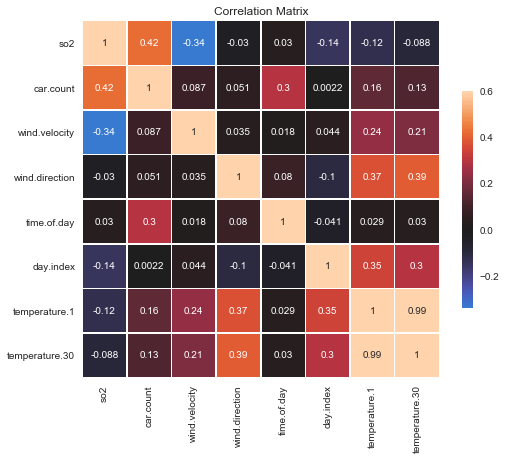

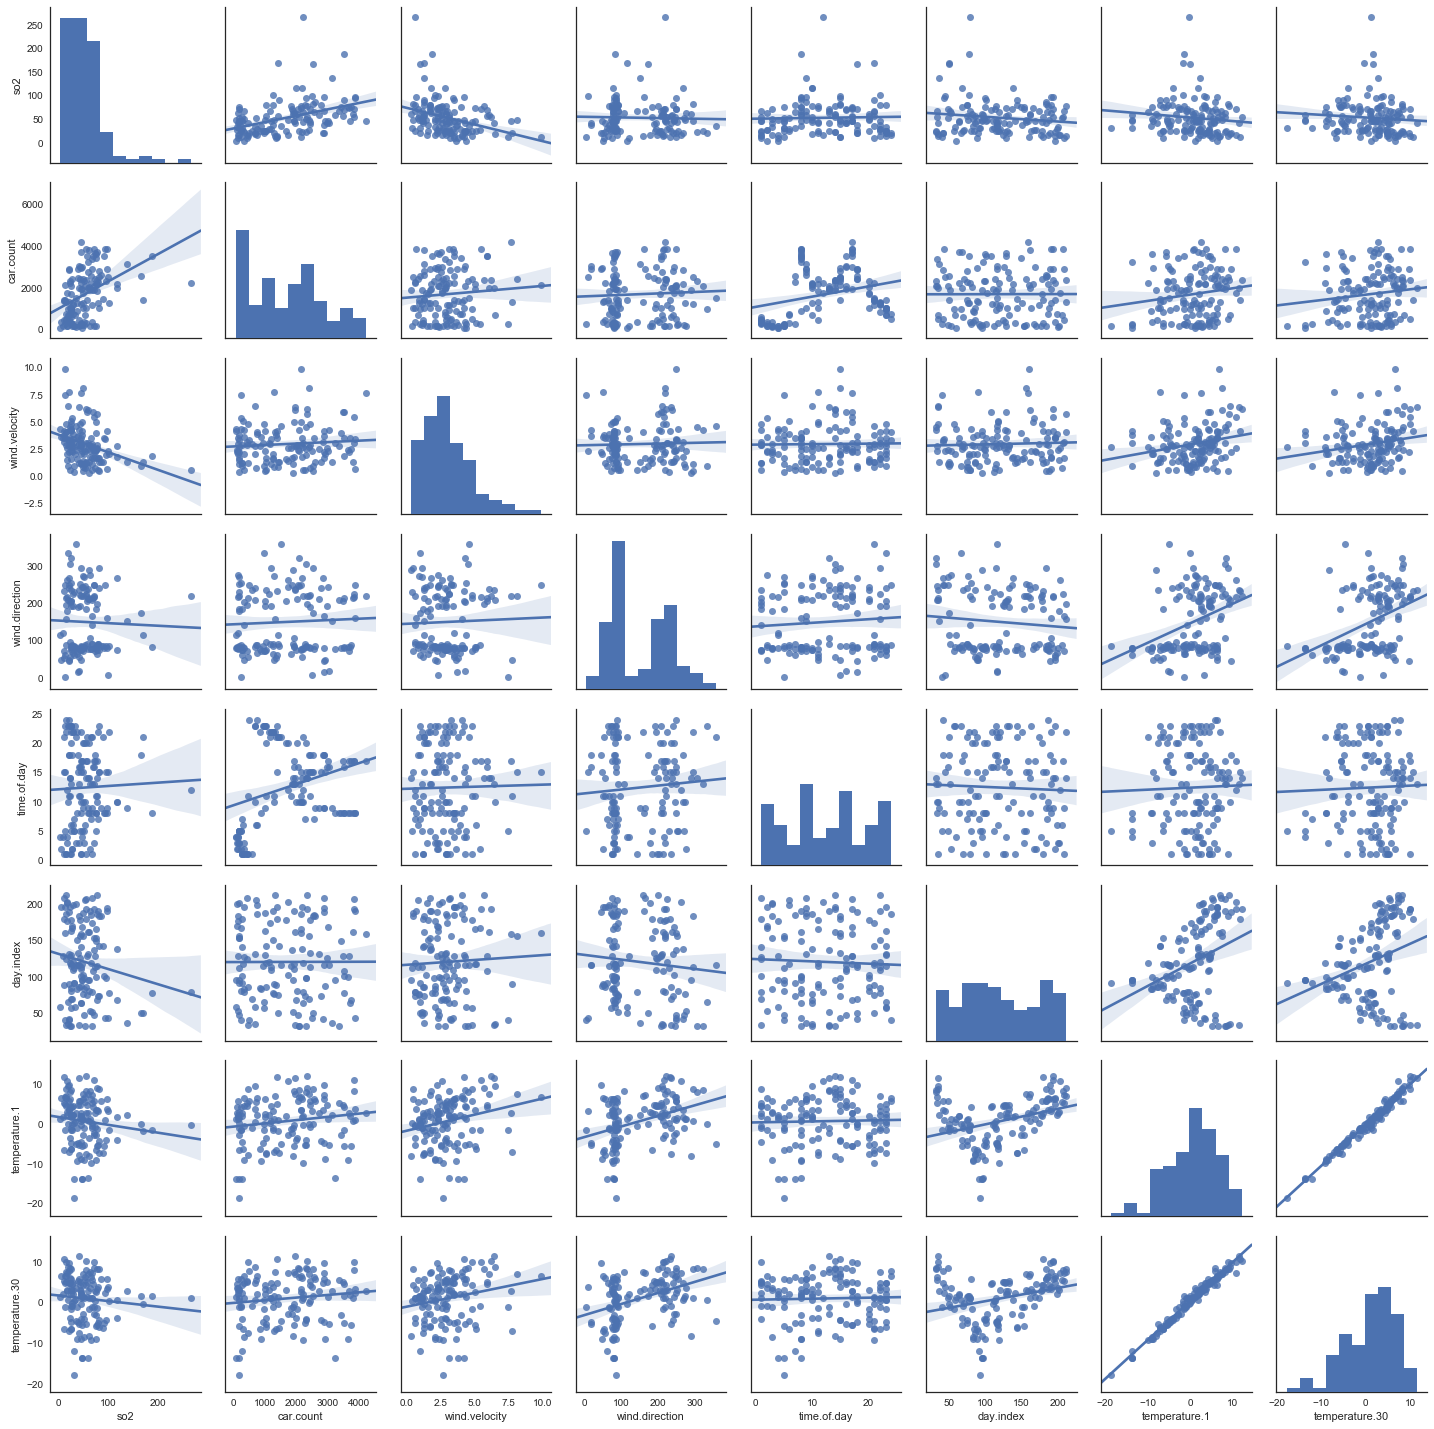

In [2]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix,center=0, annot = True, vmax = 0.6, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlation Matrix")
sns.pairplot(data_FULL, kind = "reg")

After visualising the data, I noticed:
 - **wind.direction** was split into 2 clusters (if you look at the scatter plots, or the histogram for **wind.direction**)
 - **temperature.1** and **temperature.30** had a correlation of 0.99
 - there are 2 spikes in **car.count** whenever **time.of.day** has a value of [8,9,15,16,17,18]. This corresponds to rush hour times.
 - **car.count** and **wind.speed** have the strongest correlations with **so2**, so I expect those 2 variables to be very useful in the Linear Regression model.
 
To play around with the data, I tried to create new variables.
The new variables weren't particularly useful, but I thought I should mention the steps I took anyways:
 - To represent the clustering of **wind.direction** I created a new binary variable with the following code:
 >data_FULL['wind.dir.cluster'] = [1 if x < 130 else -1 for x in all_data_FULL['wind.direction']]
 - To represent rush-hour times, I create a new binary variable with the following code:
 >data_FULL['rush.hour'] = [1 if x in (8,9,15,16,17,18) else -1 for x in all_data_FULL['time.of.day']]
 
Overall, these variables weren't that useful, so I ended up leaving them out of the final dataframe.

## Step 2: Test if Linear Regression is Appropriate

Before building a linear regression model for the data, I thought it would be useful to check if the data was actually suited for a Linear Regression model.

I walked through the following set of requirements, making sure the dataset agreed with each point:
 >**a.** *Response-predictor relationships should NOT be non-Linear*
 
 >**b.** *Error terms should not be correlated*
 
 >**c.** *Error terms should have constant variance*
 
 >**d.** *Predictor variables should not have any Collinearity* (look at corr_matrix heatmap)
 
 >**e.** *Outliers and High Leverage Points should be removed, if appropriate.* (can't really do it here...)
 
 >**f.** *At least ONE of the coefficients in the Lin.Reg equation should be non-zero.* (F-test)
 
Basically, if any part of the dataset was inappropriate for Linear Regression, I should try to eliminate that factor. 
 
For requirement **a**, I just visually inspected the top row of the pair-plot (**so2** plotted against all other variables). **so2**. 

For requirements **b**, **c** I plotted residual plots, and just inspected the residuals visually, using: <br>***sns.residplot(data_FULL["car.count"], data_FULL["so2"], lowess=True, color="g")***. <br>
I did not spot any correlation in the error terms, or any heteroskedasticity (non-constant variance), but I think next time I should probably take a more rigorous approach and conduct tests such as the Breush Pagan and the Durbin Watson tests.

For requirement **d**, I looked at the correlation matrix. **temperature.1** and **temperature.30** had a correlation of 0.99, so I removed **temperature.30** from the dataframe. All other predictor variables didn't have any noticeable correlations between themselves.

For requirement **e**, I spotted a handful of extremely high **so2** values, but I had no idea if they were caused by measurement errors or if they were real measurements, so I left those values in.

For requirement **f**, I tested the individual effect of each one of the predictor variables against **so2** to get F-values and p-values. <br> I used ***sklearn.feature_selection.f_regression()*** to do this. 2 of the variables (car.count, wind.velocity) passed this test.

## Step 3: Model-Building

The next step was to actually create the Linear Regression model. <br>
There were 3 main methods I considered:
 - **Subset Selection** - where you select a subset of variables to build your Linear Regression models with.
 - **Shrinkage** - where you use techniques like Ridge Regression.
 - **Dimension Reduction** - where you use techniques like Principle Component Analysis.
 
As of this moment in time, I understood **Subset Selection** the most, and I also thought it would be more interesting to code, so I ended up choosing the Subset Selection method. 

There were 6 predictor variables remaining after cleaning the dataset:
- **car.count**
- **wind.velocity**
- **wind.direction**
- **time.of.day**
- **day.index**
- **temperature.1**

I wanted to build a separate Linear Regression model for each combination of the 6 variables.
For example: 
 - I wanted to build a Linear Regression model with only **1** predictor variable: ${6 \choose 1} = 6 $ possible combinations.
 - I wanted to build a Linear Regression model with only **2** predictor variables: ${6 \choose 2} = 15 $ possible combinations.
 - I wanted to build a Linear Regression model with only **3** predictor variables: ${6 \choose 3} = 20 $ possible combinations.
 - I wanted to build a Linear Regression model with only **3** predictor variables: ${6 \choose 4} = 15 $ possible combinations.
 - I wanted to build a Linear Regression model with only **3** predictor variables: ${6 \choose 5} = 6 $ possible combinations.
 - I wanted to build a Linear Regression model with **all 6** variables as predictors: ${6 \choose 6} = 1 $ possible combinations.

 
Overall, there should be $2^6 = 64$ possible combinations, but we are not including the combination with **0** predictor variables, since you can't really build a regression model with that...<br>
So in the end, we end up with $2^6 - 1 = 63$ possible models to try out.<br>
Of these 63 models, the best model (with the lowest test error) would be my final model.<br>

In my code, I've represented each of these combinations as a binary number of length 6.<br>
The digit positions of the binary number correspond to the predictor variables.<br>
If a predictor variable was included in the model, then the corresponding digit in the binary number would be **1**. Otherwise, the corresponding digit would be **0**.<br>
The table below shows a few quick examples:

| car.count | wind.velocity | wind.direction | time.of.day | day.index | temperature.1 | BINARY STRING | MEANING
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 1 | 1 | 1 | 1 | 111111 | this model has **ALL 6** <br>variables included
| 0 | 0 | 0 | 1 | 0 | 0 | 000100 | this model only considers <br>**time.of.day**
| 1 | 0 | 0 | 0 | 1 | 0 | 100010 | this model only considers <br>**car.count** and **day.index**



## Step 4: Model Evaluation + Selection

I wanted to test how well each of the 63 models performed.
For this step, I had to find the test-error of each model, and I had 2 choices for this:
 - Indirectly calculate the Test-error, by adjusting the training error (e.g. Akaike Information Criterion, Adjusted $R^2$)
 - Directly calculate the Test-error, by testing the model on some holdout data (e.g. Cross Validation).
 
I thought the 2nd option (directly calculating test error) would be more fun to try out, so I went with that.<br>
I chose to go with the method of **K-Fold Cross Validation**.

Standard practice seems to be to use 5- or 10-Fold Cross Validation.
Since my cleaned data had 138 rows, which is divisble by 6, I went with 6-Fold Cross Validation.

Here, I split the data into 6 equal sections.<br>
In the 1st round, I trained my model on sections 2,3,4,5 and 6. I tested my model on section 1 to evaluate my model.<br>
In the 2nd round, I trained my model on sections 1,3,4,5 and 6. I tested my model on section 2 to evaluate my model.<br>
etc... <br>


| Round | Section 1 | Section 2 | Section 3 | Section 4 | Section 5 | Section 6 | 
| --- | --- | --- | --- | --- | --- | --- | 
| Round 1 | **TEST** | Train | Train | Train | Train | Train |
| Round 2 | Train | **TEST** | Train | Train | Train | Train |
| Round 3 | Train | Train | **TEST** | Train | Train | Train |
| Round 4 | Train | Train | Train | **TEST** | Train | Train |
| Round 5 | Train | Train | Train | Train | **TEST** | Train |
| Round 6 | Train | Train | Train | Train | Train | **TEST** |


At the end of all 6 rounds, I averaged all 6 test-errors to find the average test-error for that model.
I measured test-error by finding the **Mean Square Error**, between the model's predicted values and the actual values of $SO_2$.

I repeated this each time, for all 63 models, to get an average test-error for each model.
The model with the lowest test error is the best one.

## Step 5: The Code...

Here's my actual code.

In [3]:
#data_FULL = pd.read_csv("TRAINING_DATA.txt")
#data_FULL = data_FULL.drop_duplicates()

# to get rid of a high collinearity predictor variable.
data_FULL = data_FULL.drop(columns=["temperature.30"])

In [4]:
def multi_lin_reg(X_tr, X_te, Y_tr, Y_te):
    """
    Inputs: 
        - X_tr = predictor training data
        - X_te = predictor test data
        - Y_tr = response training data
        - Y_te = response test data
        
    Outputs:
        - Dictionary of values, from the LinReg model.
        
        
    f(x)
        - Give it a list of train and test data, and it will fit a
            Linear Regression model on the data, and test the model,
            and give you some useful statistic.
        
    """
    # fits regression model to Training Data (X_tr, Y_tr)
    regr = linear_model.LinearRegression()
    regr.fit(X_tr, Y_tr)
    
    # makes predictions for Y, using Test Data (X_te)
    Y_pred = regr.predict(X_te)
    
    model_results = {}
    model_results['X_variables'] = X_tr.columns.values.tolist()
    model_results['Coefficients'] = regr.coef_
    model_results['MeanSqError'] = mean_squared_error(Y_te, Y_pred)
    model_results['R2_Score'] = r2_score(Y_te, Y_pred)
    model_results['Ytest_vs_Ypred'] = list(zip(Y_te, Y_pred))
    
    return model_results

In [5]:
def generate_bin_strings(N):
    """
    Generates all possible binary strings, up to length N.
    Use to represent the combinations of possible model predictors
    """
    total = 2**N
    bin_strings = []
    for i in range(1, total):
        bin_str = bin(i)[2:].zfill(N)
        bin_strings.append(bin_str)
    #print("Total = " + str(total))
    return bin_strings   

In [6]:
def binary_locate_in_df(dataframe ,binarystring):
    """
    Cuts down the dataframe so that it matches the binary string.
    """
    temp_df = dataframe
    remove_list = []
    for i in range(0, len(binarystring)):
        #print(i, int(binarystring[i]), temp_df.columns[i])
        #print(binarystring[i])
        #print(temp_df.columns[i])
        if int(binarystring[i]) == 0:
            remove_list.append(int(i))
    
    temp_df = temp_df.drop(temp_df.columns[remove_list], axis = 1)      
   
    return temp_df

In [7]:
def cross_validated_score(Y_full, X_full, N = 6):
    """
    INPUT: The Y- and X- parts of the data you want to Cross Validate.
            N = number of folds in the K-fold CV process (i.e. K)
    OUTPUT: Scores for all N tests. And AVG score.
    """
    scores = []
    
    kfold_splitter = KFold(n_splits = N)
    
    for train_ind, test_ind in kfold_splitter.split(Y_full):
        Y_train_temp = Y_full.iloc[train_ind]
        Y_test_temp = Y_full.iloc[test_ind]
        
        X_train_temp = X_full.iloc[train_ind]
        X_test_temp = X_full.iloc[test_ind]
        
        # for each batch in the K-fold split set,
        # run the multi_lin_reg() function and get a score
        temp_results = multi_lin_reg(X_train_temp,
                                     X_test_temp,
                                     Y_train_temp,
                                     Y_test_temp)
        
        scores.append(temp_results['MeanSqError']) #CHANGE ME TO MeanSqError pls later
        #scores.append(temp_results)
        
    avg_score = sum(scores)/ float(len(scores)) # or could use np.mean() maybe..
    
    return avg_score, #scores

In [8]:
def big_function_overall(full_df, binary_string):
    
    Y_main = full_df["so2"]
    #X_main = full_df.drop(["so2", "temperature.30"], axis = 1)# inefficient.
    X_main = full_df.drop(["so2"], axis = 1)# inefficient.
    
    cut_down_df = binary_locate_in_df(X_main ,binary_string)
    
    # >>> now, you have the cut down df.
    # >>> Y_main = so2
    # >>> cut_down_df = reminaing X variables,after 001100101....etc
    final_scorrrrres = cross_validated_score(Y_main, cut_down_df, 10)
    
    return final_scorrrrres #WORKS!!!!

In [9]:
list_of_bin_str = generate_bin_strings(6)

final_dictionary = {}
for i in list_of_bin_str:
    final_dictionary[str(i)] = big_function_overall(data_FULL, str(i))
    
    
    # OK WORKS
    # Best model, with least MeanSqError AVG (5-fold CV) is the 110101` model
    # All the top models have 11xxxx, which is expected since the first 2
    #   variables had the best correlation with so2.
    
    # The worst possible model was just 001111 (with highest MSE) which makes sense too.
    # Because this model ignored the 2 best predictors... then just took the worst 4
    # and created a model using that... 
    
    # And the same good models return the highest R2 scores (~ 0.24)
    # And the same bad models return the lowest R2 scores (~ -0.22)

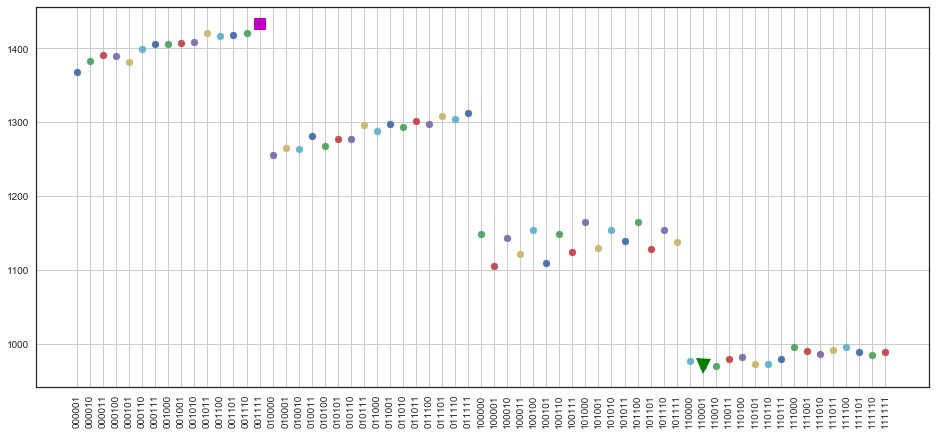

In [15]:

### RESULTS PLOTTING - Plot a scatter graph of model vs avg score.
### -------------------------------------------------------------+
plt.figure(figsize=(16,7)) 
for key in final_dictionary:
   #print(key, final_dictionary[key][0])
   plt.scatter(key, final_dictionary[key][0])
plt.plot("110001", 969.8104, "gv", markersize = 15)
plt.plot("001111", 1432.6133, "ms", markersize = 12)
plt.grid()
plt.xticks(rotation='vertical'); # <---- added a semicolon, suppresses all the extra text...


In [27]:
#To test our best model: car.count, wind.velocity, temperature.1

import statsmodels.api as sm
import statsmodels.formula.api as smf

Y_test = data_FULL["so2"]
X_test = data_FULL.drop(["so2", "wind.direction", "time.of.day", "day.index"], axis = 1)

regression1 = smf.OLS(Y_test, X_test, data = data_FULL).fit()
print(regression1.summary())

                            OLS Regression Results                            
Dep. Variable:                    so2   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     95.39
Date:                Thu, 28 Jun 2018   Prob (F-statistic):           3.14e-38
Time:                        18:53:12   Log-Likelihood:                -678.00
No. Observations:                 138   AIC:                             1364.
Df Residuals:                     134   BIC:                             1376.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
car.count          0.0249      0.002     12.

### NEED TO DO; IMPROVEMENTS + FUTURE WORK

For residuals:
 - Test Normality with Jarque-Bera test
 - Test Heteroskedasticity with Breush Pagan test or White test.
 - Test autocorrelation with Durbin-Watson test.
 - Ref: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Violations_of_Regression_Models/notebook.ipynb
 
 
For the actual model
 - Test for significance. Is the model actually better than just a constant? Find p-value.
 - http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test
 - http://blog.minitab.com/blog/adventures-in-statistics-2/what-is-the-f-test-of-overall-significance-in-regression-analysis
 
 
Other stuff:
 - Add interaction terms maybe
 - Might be easier to rewrite everything using statsmodels instead of sklearn...
 - Remove Outliers + HighLeveragePoints and see what happens
 - Merge a few functions into larger ones, as function calls are computationally expensive (i think)